# QIPE NOTEBOOK

#### Quantum Image Pattern Encoding based on grover's search algorithm is a proposed data encoding method in quantum systems. This is basis encoding method where pattern's pixel location will be encoded as a high amplitude basis states. QIPE uses <b>generalized grover's algorithm</b> to encode data points in grover's oracle circuit.

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from PIL import Image
from numpy import asarray
import itertools

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.providers.fake_provider import FakeVigo
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel

# import basic plot tools
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix
from qiskit.visualization import plot_state_city

# link to grovers algorithm notebook: https://qiskit.org/textbook/ch-algorithms/grover.html
# to install quiskit textbook libray
#! pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

EncodingAmplitudeAccuracy = 1

In [2]:
def oracle(qubitList, winState):
    m = math.floor(3.14*EncodingAmplitudeAccuracy/(4*(math.asin(math.sqrt(len(winState)/math.pow(2,len(qubitList)))))))
    print("Circuit Repetetion = ", m)
    if m == 0:
        raise Exception ("circuit not possible")
    final_oracleCir = QuantumCircuit(len(qubitList))
    oracleCir = QuantumCircuit(len(qubitList))
    exeCount = 0
    for ws in winState:
        exeCount +=1
        if len(ws) != len(qubitList):
            raise Exception ("invalid state with respect to the number of qubits")
        #if exeCount > 1: 
        qPos = 0
        for bit in ws:
            if bit == '0':
                oracleCir.x(len(qubitList)-1-qPos)
            qPos +=1  
        oracleCir.h(len(qubitList)-1)
        nq = len(qubitList)
        oracleCir.mct(list(range(nq-1)), nq-1)               # multi-controlled-toffoli
        oracleCir.h(len(qubitList)-1)
        qPos = 0
        for bit in ws:
            if bit == '0':
                oracleCir.x(len(qubitList)-1-qPos)
            qPos +=1

    return oracleCir


#n-bit generelized diffuser from quiskit git
def diffuser(qubitList):
    nqubits = len(qubitList)
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Diffuser:"+str(len(qubitList))+"qubits"
    return U_s


def statevec(qc):
    if STATE_VECTOR == True:
        sim = Aer.get_backend('aer_simulator')
        grover_circuit_sim = qc.copy()
        grover_circuit_sim.save_statevector()
        qobj = assemble(grover_circuit_sim)
        result = sim.run(qobj).result() # Do the simulation and return the result
        out_state = result.get_statevector()
        return out_state
    else:
        return None


def statevec2(qc):
    if STATE_VECTOR == True:
        sim = Aer.get_backend('aer_simulator')
        # we need to make a copy of the circuit with the 'save_statevector'
        # instruction to run on the Aer simulator
        grover_circuit_sim = qc.copy()
        grover_circuit_sim.save_statevector()
        qobj = assemble(grover_circuit_sim)
        result = sim.run(qobj).result()
        statevec = result.get_statevector()
        from qiskit_textbook.tools import vector2latex
        vector2latex(statevec, pretext="|\\psi\\rangle =")
    else:
        return None

In [3]:
def winStateGen(imgPath, sizeW, sizeL):
    im = Image.open(imgPath)
    im = im.resize((sizeW,sizeL))
    numpydata = asarray(im)
    winState = []
    for x in range(len(numpydata)):
        for y in range(len(numpydata)):
            if (numpydata[x][y] > 50):
                #print(x,y)
                #winState.append(str(decimalToBinary(x))+str(decimalToBinary(y)))
                winState.append((str(format(x, '03b'))+str(format(y, '03b'))))
    return winState

def highAmpState(simResDic, numOfoutput):
    l = [simResDic[a] for a in simResDic]
    l.sort(reverse=True)
    HAS = []
    count = []
    for x in range(numOfoutput):
        HAS.append(list(simResDic.keys())[list(simResDic.values()).index(l[x])])
        count.append(l[x])
    return HAS

In [4]:
w_s = []
def QIPE(ImageLoc, imageSize):
    w_s = winStateGen(imloc,imageSize[0], imageSize[1])
    n = imageSize[0]*imageSize[1]
    QIPE_c = genGroverCiruit(math.log2(n), w_s) 
    return QIPE_c

def genGroverCiruit(total_num_of_Qubit, winState):
    Qlist = [q for q in range(int(total_num_of_Qubit))]
    Grover_Circuit = QuantumCircuit(len(Qlist))
    for x in range(len(Qlist)):
        Grover_Circuit.h(x)
        Grover_Circuit.barrier(x)
    totaloracle = oracle(Qlist, winState)
    diff = diffuser(Qlist)
    m = math.floor((3.14*EncodingAmplitudeAccuracy)/
                   (4*(math.asin(math.sqrt(len(winState)/math.pow(2,total_num_of_Qubit))))))
    # print("m = " ,m)
    for n in range(m):
        Grover_Circuit.append(totaloracle, Qlist)
        Grover_Circuit.append(diff, Qlist)
    return Grover_Circuit

def simulator(QC,numshots):
    QC.measure_all()
    aer_sim = Aer.get_backend('aer_simulator', device= 'CPU')
    transpiled_grover_circuit = transpile(QC, aer_sim)
    qobj = assemble(transpiled_grover_circuit)
    results = aer_sim.run(qobj,shots = numshots).result()
    counts = results.get_counts()
    return counts

def simulatorWtnoise(QC,Nshots):
    provider = IBMQ.load_account()
    backend = provider.get_backend('ibm_oslo')
    noise_model = NoiseModel.from_backend(backend)

    QC.measure_all()
    # Perform a noise simulation
    result = execute(QC, Aer.get_backend('qasm_simulator'),
                     noise_model=noise_model, shots=Nshots).result()
    counts = result.get_counts(0)
    return counts
    

# 

# <center><u>Select the image to encode:</u></center>

In [5]:
imloc = "./img_1.jpg"
QP_c = QIPE(imloc, [8, 8])
QP_c.draw()

Circuit Repetetion =  1


┌───┐ ░ ┌─────────────┐┌───────────────────┐
q_0: ┤ H ├─░─┤0            ├┤0                  ├
     ├───┤ ░ │             ││                   │
q_1: ┤ H ├─░─┤1            ├┤1                  ├
     ├───┤ ░ │             ││                   │
q_2: ┤ H ├─░─┤2            ├┤2                  ├
     ├───┤ ░ │  circuit-89 ││  Diffuser:6qubits │
q_3: ┤ H ├─░─┤3            ├┤3                  ├
     ├───┤ ░ │             ││                   │
q_4: ┤ H ├─░─┤4            ├┤4                  ├
     ├───┤ ░ │             ││                   │
q_5: ┤ H ├─░─┤5            ├┤5                  ├
     └───┘ ░ └─────────────┘└───────────────────┘

In [6]:
STATE_VECTOR = True
aer_sim = Aer.get_backend('aer_simulator', device= 'CPU')
transpiled_circuit = transpile(QP_c, aer_sim)
statevec2(transpiled_circuit)

<IPython.core.display.Math object>

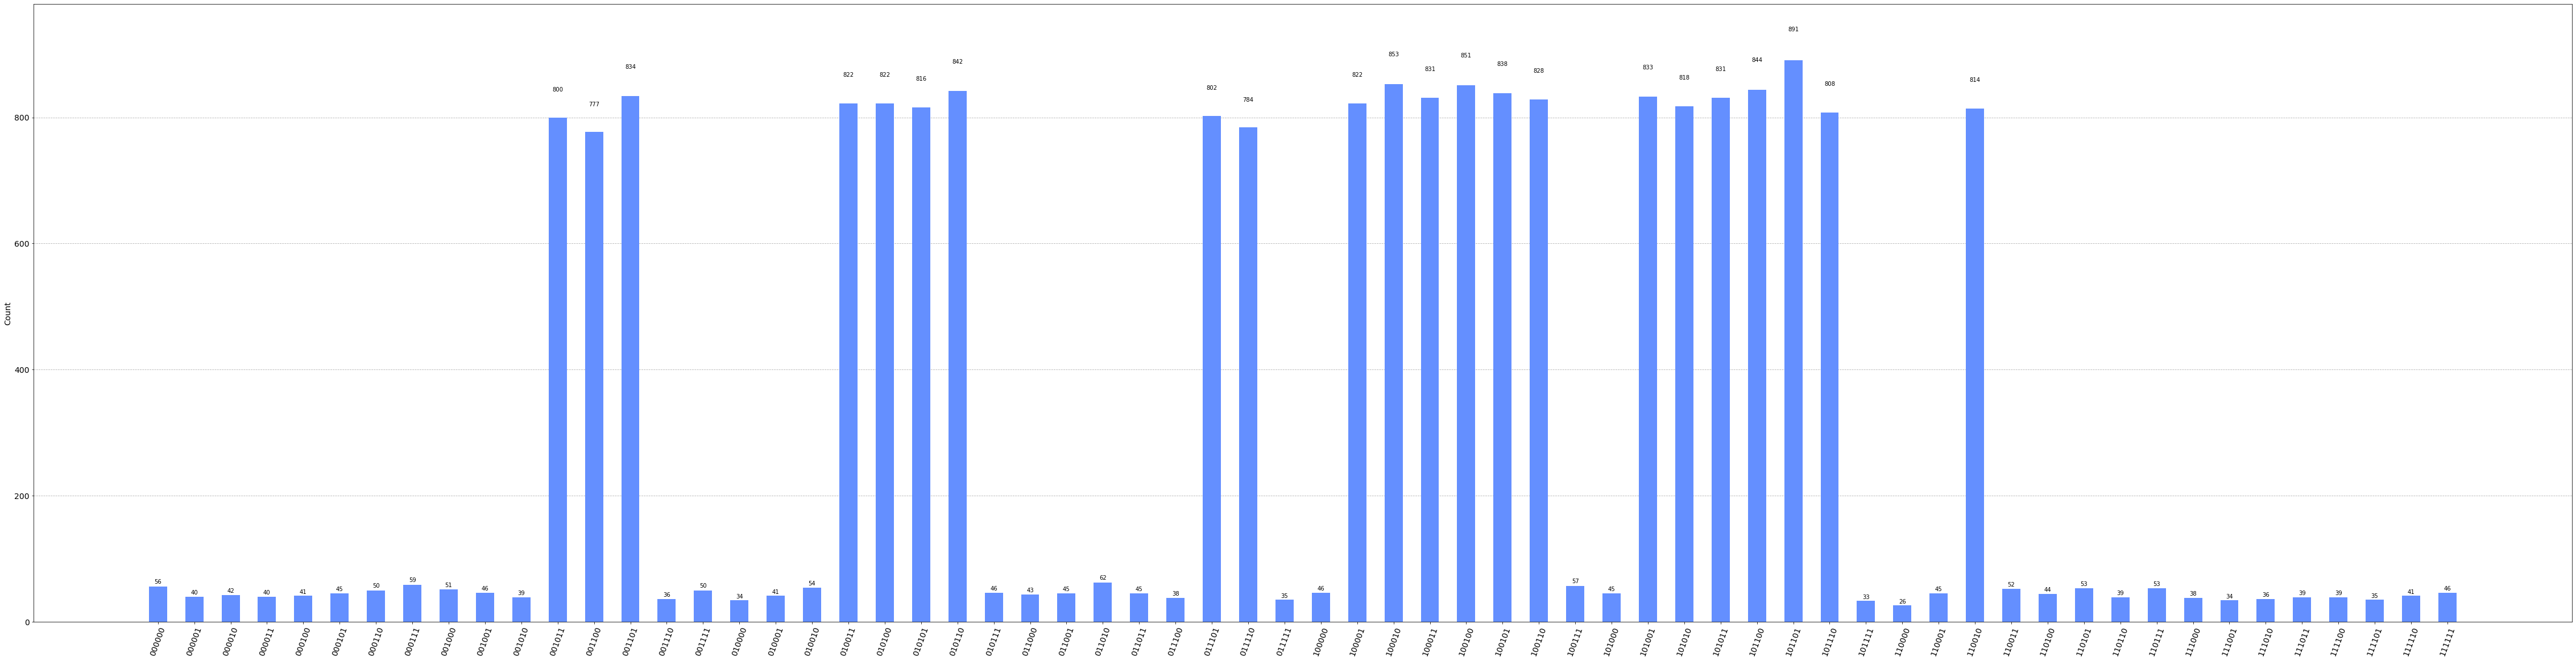

In [7]:
# Data Encoded (Pattern from Image) in Quantum Basis
counts = simulator(QP_c, 20000)
plot_histogram(counts, (80, 20))

In [8]:
hs = highAmpState(counts, 47)

In [9]:
hs

['101101',
 '100010',
 '100100',
 '101100',
 '010110',
 '100101',
 '001101',
 '101001',
 '101011',
 '101011',
 '100110',
 '100001',
 '100001',
 '100001',
 '101010',
 '010101',
 '110010',
 '101110',
 '011101',
 '001011',
 '011110',
 '001100',
 '011010',
 '000111',
 '100111',
 '000000',
 '010010',
 '110101',
 '110101',
 '110011',
 '001000',
 '000110',
 '000110',
 '111111',
 '111111',
 '111111',
 '111111',
 '101000',
 '101000',
 '101000',
 '101000',
 '101000',
 '110100',
 '011000',
 '000010',
 '111110',
 '111110']

In [10]:
# n = 6
# sqs = [''.join(s) for s in list(itertools.product(*[['0', '1']] * n))]
# QP = genGroverCiruit(n, sqs[:(2**(n-1))-1])
# # QP.measure_all()
# QP.measure_all()
# # QP.draw()

In [11]:
# aer_sim = Aer.get_backend('aer_simulator', device= 'CPU')
# transpiled_circuit = transpile(QP, aer_sim)
# # transpiled_circuit.depth()
# # transpiled_circuit.draw(output="mpl", idle_wires=False)

In [12]:
# counts = simulator(QP, 10000)
# qobj = assemble(transpiled_circuit)
# results = aer_sim.run(qobj,shots = 20000).result()
# counts = results.get_counts()
# plot_histogram(counts, (80, 20))

Circuit Repetetion =  12
Circuit Repetetion =  8
Circuit Repetetion =  7
Circuit Repetetion =  6
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  2
Circuit Repetetion =  1
Circuit Repetetion =  1
Circuit Repetetion =  1
Circuit Repetetion =  1
Circuit Repetet

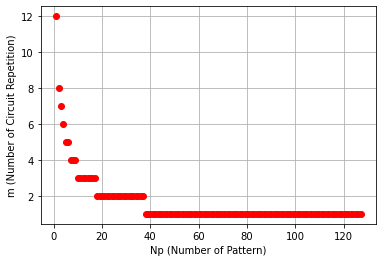

In [13]:
n = 8
sqs = [''.join(s) for s in list(itertools.product(*[['0', '1']] * n))]
aer_sim = Aer.get_backend('aer_simulator', device= 'CPU')
count = 0

plt.xlabel("Np (Number of Pattern)")
plt.ylabel("m (Number of Circuit Repetition)")
plt.grid()

for i in range(1, 2**n):
    Np = i
    m = math.floor((3.14*EncodingAmplitudeAccuracy)/(4*(math.asin(math.sqrt(Np/(2**n))))))
    if m == 0:
        break
    QP = genGroverCiruit(n, sqs[:Np])
    
    T_depth = transpile(QP, aer_sim).depth()
    if m == 0 and count == 0:
        print(Np)
        count = 1
    plt.plot(Np, m, 'o', color = "red")
    # plt.plot(T_depth, m, 'o', color = "blue")

plt.show()

Circuit Repetetion =  25
Circuit Repetetion =  17
Circuit Repetetion =  14
Circuit Repetetion =  12
Circuit Repetetion =  11
Circuit Repetetion =  10
Circuit Repetetion =  9
Circuit Repetetion =  8
Circuit Repetetion =  8
Circuit Repetetion =  7
Circuit Repetetion =  7
Circuit Repetetion =  7
Circuit Repetetion =  6
Circuit Repetetion =  6
Circuit Repetetion =  6
Circuit Repetetion =  6
Circuit Repetetion =  6
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  5
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  4
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Repetetion =  3
Circuit Re

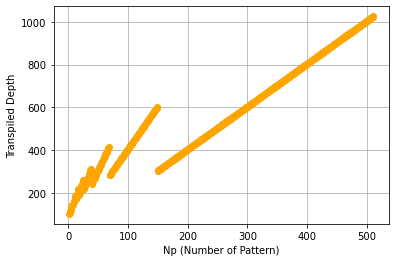

In [14]:
n = 10
count = 0
sqs = [''.join(s) for s in list(itertools.product(*[['0', '1']] * n))]

plt.ylabel("Transpiled Depth")
plt.xlabel("Np (Number of Pattern)")
plt.grid()

for i in range(1, 2**n):
    Np = i
    m = math.floor((3.14*EncodingAmplitudeAccuracy)/(4*(math.asin(math.sqrt(Np/(2**n))))))
    if m == 0:
        break
    QP = genGroverCiruit(n, sqs[:Np])
    
    T_depth = transpile(QP, aer_sim).depth()
    if m == 0 and count == 0:
        print(Np)
        count = 1
    # plt.plot(Np, m, 'o', color = "red")
    plt.plot(Np, T_depth, 'o', color = "orange")

plt.show()